# HR Dataset Investigation

In [1]:
import pandas as pd
import acquire
import prepare

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


## Predict the probability of an candidate looking for a new job
Möbius · 23 Submissions · a month to go

Task Details
This dataset designed to understand the factors that lead a person will work for the company(leaving current job) ,and the goal of this task is building model(s) that uses the current credentials,demographics,experience to predict the probability of a candidate looking for a new job or will work for the company.

The whole data divided to train and test . Also sample submission has been provided correspond to enrollee_ id of test set ( enrolle_ id | target)

Note:

The dataset is imbalanced so it might affect your result if you dont handle it
Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality so encoding methods and techniques will help to boost models performance
Missing imputation strategy might affect the results so it can be a part of your pipeline as well.
Expected Submission
Solution Notebook with following mandatory outputs:

Prediction: for each row in test data the predicted probability of candidate looking for a job, (probability of the class with the greater label).Format is given in sample_submission.csv:
enrollee_id : Unique ID for enrollee
target : probability of an enrollee looking for a job change
Model Evaluation: roc_ auc_ score of (answer,prediction probability of rows in test data)
*answer: test target values(download from : https://www.kaggle.com/arashnic/job-change-dataset-answer)
Model Interpretation: Interpret model(s) such a way that illustrate which features affect candidates decision
Evaluation
The evaluation metric is area under the ROC curve score.

You have better first evaluate your model(s) with your selected strategy (KFold CV, hold_ out,…) and then predict test (sample_submission) and finally compare the result for your own with test target values and find out your model performance on unseen data and your model fitness.

The pipeline you apply for getting result (EDA, preprocessing, feature engineering and selection , model building and evaluation strategy and so on, will be evaluated by your model performance on unseen data(aug_test.csv)

**Goals**  
- Predict the probability of a candidate will work for the company
- Interpret model(s) such a way that illustrate which features affect candidate decision


In [2]:
# read in Kaggle dataset, use enrollee_id as index
# note: Kaggle has provided seperate train and test datasets, do not need to split
HRtrain = pd.read_csv('aug_train.csv')
HRtest = pd.read_csv('aug_test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
HRtrain.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
HRtest.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [5]:
sample.head()

,enrollee_id,target
0,32403,0.5
1,9858,0.5
2,31806,0.5
3,27385,0.5
4,27724,0.5


In [6]:
HRtrain.shape

(19158, 14)

In [7]:
HRtest.shape

(2129, 13)

In [8]:
sample.shape

(2129, 2)

## Notes from Kaggle setup

- The final submission appears to be a list of enrollee_id where I need to predict a 0 or 1 for each id
- so given the information in the training dataset build a model then use that model to predict the target value for the enrollees in the test set
- given the almost 20K observations in the train dataset will split this into train, validate, test to build and evaluate model prior to using on provided test dataset


## Data definitions from Kaggle


enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

## clean up done as part of Acquire
- drop enrollee_id as this is unique identifier that will not be used for exploration or modeling
- fill NA in Gender with not_identified as category
- drop all null values?
    - reduces from 19K to 9K observations, this is too much loss
    - instead fill all na with "not_identified"
    

# Prepare

- check for null values
- determine if will need to impute any null values from train_df
- will start with added category of 'not_identified' for null values
- will split HRtrain into train, validate, test

In [9]:
# checking for null values that will need to be addressed
HRtrain.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [10]:
# what are the values in gender?
HRtrain.gender.value_counts()

Male      13221
Female     1238
Other       191
Name: gender, dtype: int64

In [11]:
HRtrain.enrolled_university.value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

In [12]:
HRtrain = HRtrain.fillna("not_identified")

In [13]:
HRtrain.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [14]:
HRtrain.shape

(19158, 14)

In [15]:
# what are the values in gender?
HRtrain.gender.value_counts()

Male              13221
not_identified     4508
Female             1238
Other               191
Name: gender, dtype: int64

In [16]:
HRtrain.enrolled_university.value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
not_identified        386
Name: enrolled_university, dtype: int64

In [17]:
HRdata = acquire.run()
train, vaildate, test = prepare.prep_data(HRdata)

Acquire: compiling raw data files...
Acquire: Completed!
Preparing Data...
Prepare Completed
train shape, validate shape, test shape
(10728, 13) (4598, 13) (3832, 13)


In [18]:
train.describe(include='all')

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,10728,10728.000000,10728,10728,10728,10728,10728,10728,10728,10728,10728,10728.000000,10728.000000
unique,120,NaN,4,2,4,6,7,23,9,7,7,NaN,NaN
top,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,not_identified,Pvt Ltd,1,NaN,NaN
freq,2385,NaN,7423,7709,7699,6491,8160,1826,3317,5485,4502,NaN,NaN
mean,NaN,0.828582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.585850,0.249348
std,NaN,0.123106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.795047,0.432655
min,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,0.738000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,0.000000
50%,NaN,0.899000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.500000,0.000000
75%,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.000000,0.000000


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10728 entries, 1504 to 8063
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    10728 non-null  object 
 1   city_development_index  10728 non-null  float64
 2   gender                  10728 non-null  object 
 3   relevent_experience     10728 non-null  object 
 4   enrolled_university     10728 non-null  object 
 5   education_level         10728 non-null  object 
 6   major_discipline        10728 non-null  object 
 7   experience              10728 non-null  object 
 8   company_size            10728 non-null  object 
 9   company_type            10728 non-null  object 
 10  last_new_job            10728 non-null  object 
 11  training_hours          10728 non-null  int64  
 12  target                  10728 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(10)
memory usage: 1.1+ MB


# Explore

## Visualization Ideas
- target with each feature
    - training hours with city development
    - seem to be more looking for job at lower city index, but maybe just fewer people?
        - bin city_development_index for comparison


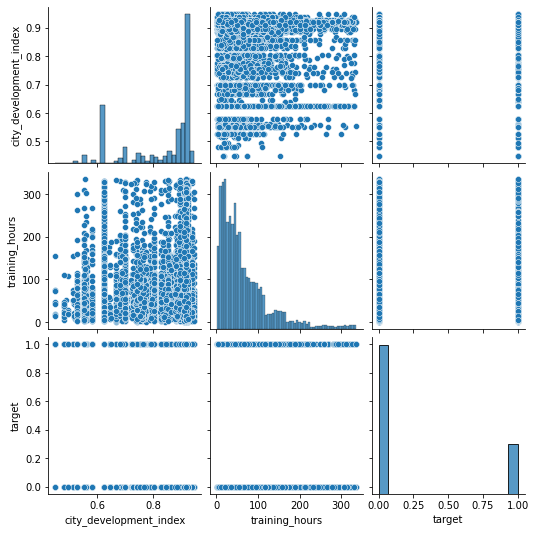

In [20]:
# create pair plot to see all features visually
sns.pairplot(data=train)

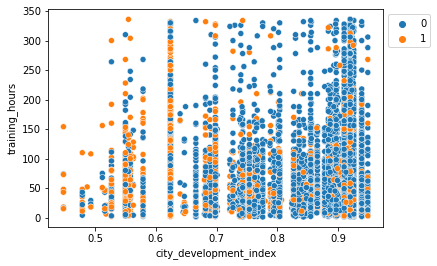

In [21]:
# possible relationship between city_development_index and training_hours
# create visual of those two with target
sns.scatterplot(data=train, x='city_development_index', y='training_hours', hue='target')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
# https://www.geeksforgeeks.org/how-to-place-legend-outside-the-plot-with-seaborn-in-python/

In [22]:
# seems like more orange dots in with lower city_development_index, but might be because overall are fewer dots?
# bin city development into groups with equal numbers of observations
train['city_dev_bin'] = pd.cut(train.city_development_index, 3, labels=['low', 'med', 'high'])

In [23]:
train.city_dev_bin.value_counts()

high    7497
med     2839
low      392
Name: city_dev_bin, dtype: int64

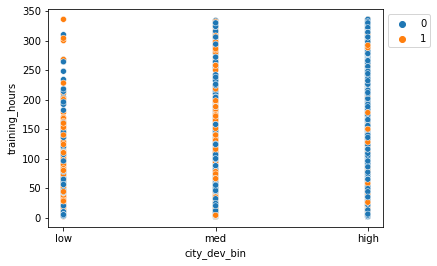

In [24]:
sns.scatterplot(data=train, x='city_dev_bin', y='training_hours', hue='target')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [25]:
round(pd.crosstab(train.city_dev_bin, train.target, margins=True, normalize=False), 2)

target,0,1,All
city_dev_bin,,,
low,162,230,392
med,1594,1245,2839
high,6297,1200,7497
All,8053,2675,10728


**Takeaways**     
- cutting city_development_index into bins spread equally across the range of values
    - 70% of observations = High
    - 25% = Medium
    - 4% = Low index score bin
- 25% of the total observations are looking for a job change, most of whom are in the low or med bin
    - almost 2/3 (58.7%) in the low bin are looking for a job change
    - just under half (45.6%) of those in the med bin are looking for a job change
    - only 16% of those in the high bin are looking for a job change

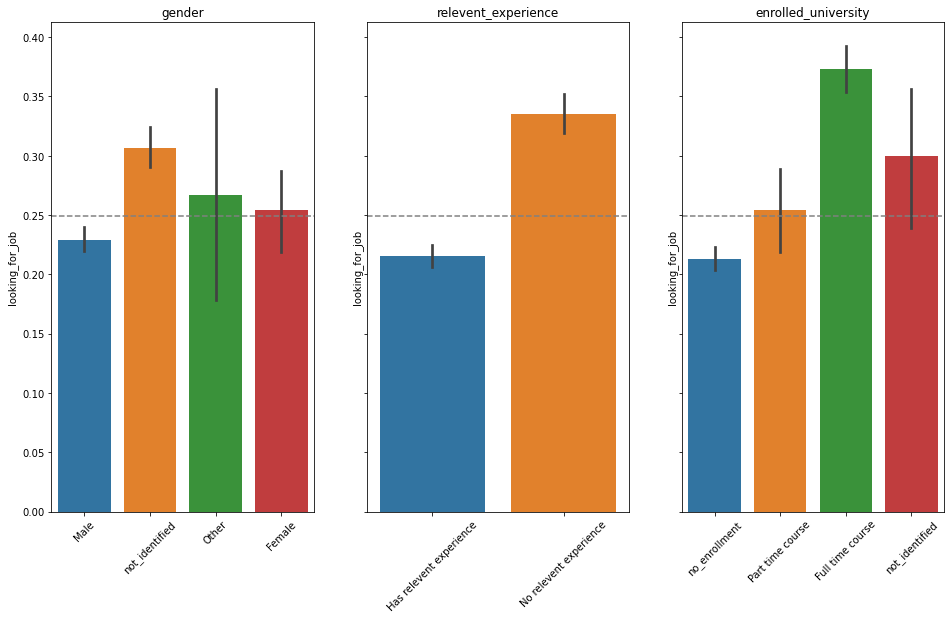

In [26]:
features = ['gender', 'relevent_experience', 'enrolled_university']

looking_for_job = train.target.mean()
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 9), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'target', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('looking_for_job')
    ax[i].set_title(feature)
    ax[i].axhline(looking_for_job, ls='--', color='grey')
    ax[i].tick_params(axis='x', rotation=45)

**Takeaways**
- those with no relevant experience and those enrolled in full time course are more likely to be looking for a job

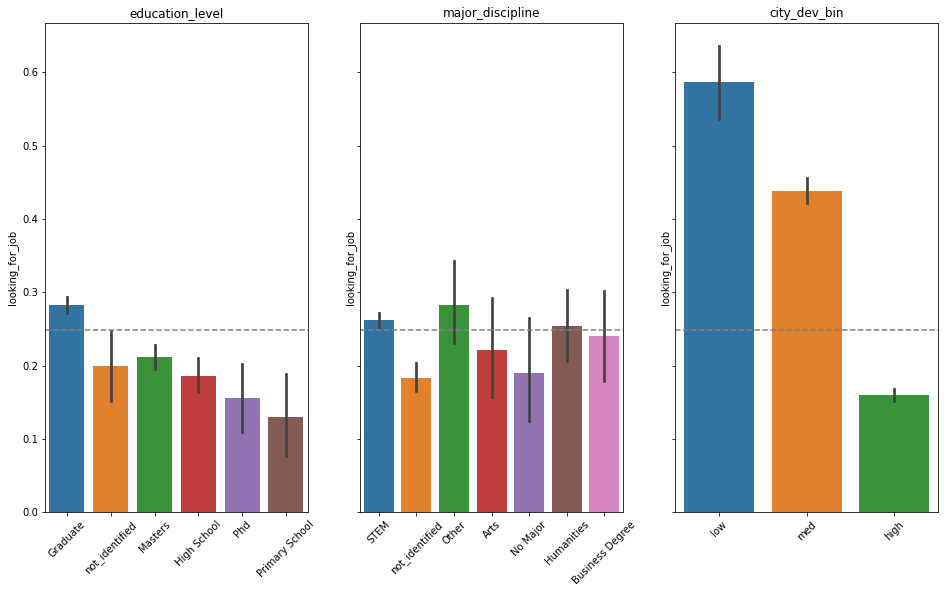

In [27]:
features = ['education_level', 'major_discipline', 'city_dev_bin']

looking_for_job = train.target.mean()
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 9), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'target', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('looking_for_job')
    ax[i].set_title(feature)
    ax[i].axhline(looking_for_job, ls='--', color='grey')
    ax[i].tick_params(axis='x', rotation=45)

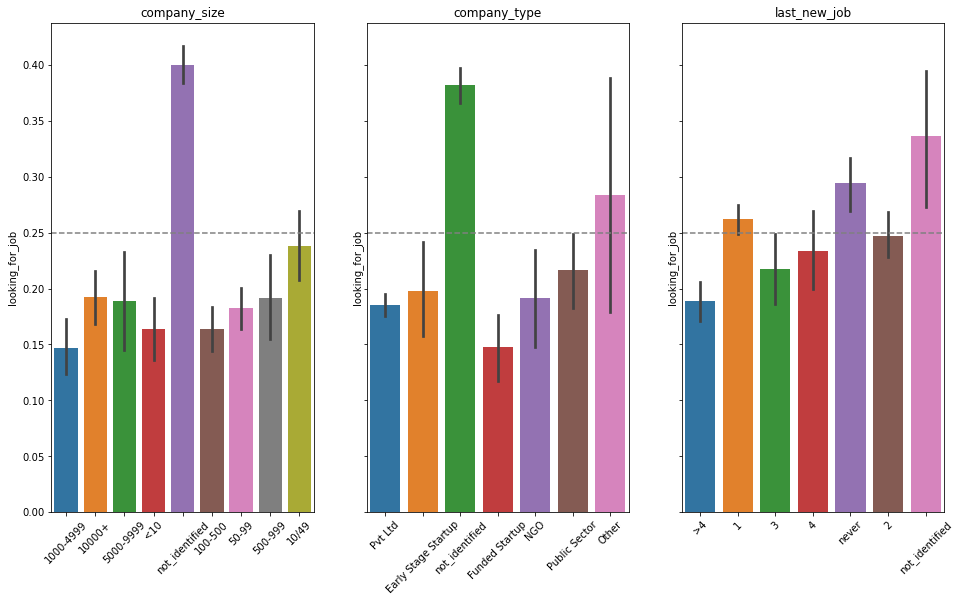

In [28]:
features = ['company_size', 'company_type', 'last_new_job']

looking_for_job = train.target.mean()
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 9), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'target', data=train, ax=ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('looking_for_job')
    ax[i].set_title(feature)
    ax[i].axhline(looking_for_job, ls='--', color='grey')
    ax[i].tick_params(axis='x', rotation=45)

**Takeaways**   
- those who did not identify tend to be looking for job
    - this makes sense as those are looking for a job may be concerned that current employer would find out


<AxesSubplot:xlabel='experience', ylabel='target'>

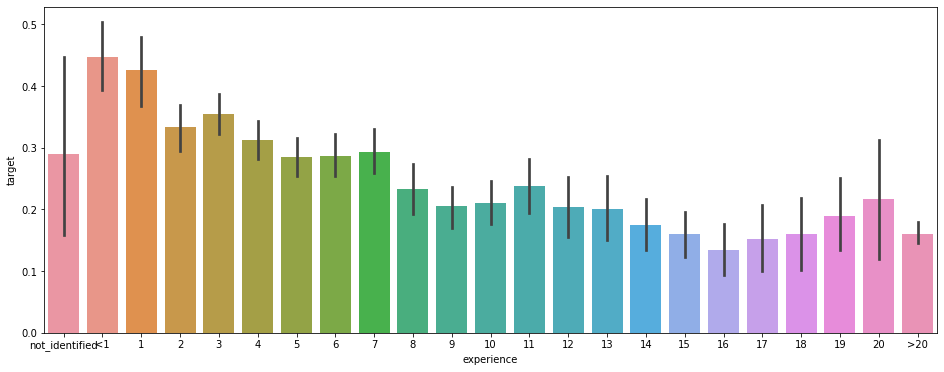

In [29]:
# visualize experience
plt.figure(figsize=(16, 6))
xorder = ['not_identified', '<1', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', 
         '15', '16', '17', '18', '19', '20', '>20']
sns.barplot(data=train, x='experience', y='target', order=xorder)

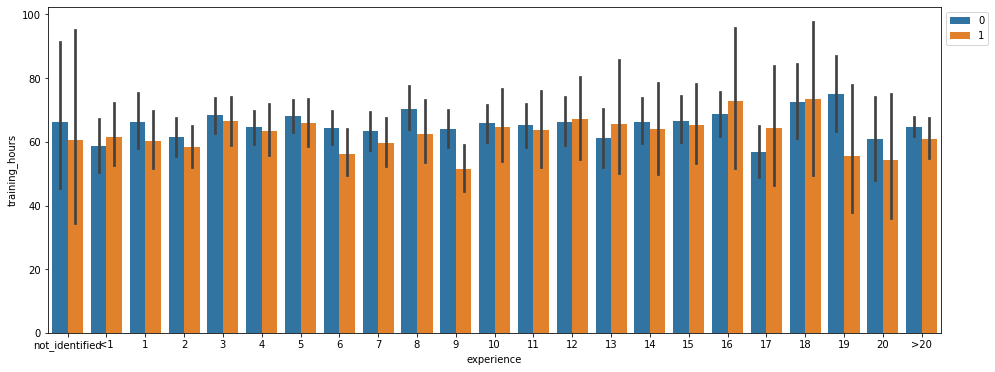

In [30]:
# visualize training hours and experience with target as hue
plt.figure(figsize=(16, 6))
sns.barplot(data=train, x='experience', y='training_hours', hue='target', order=xorder)
plt.legend(bbox_to_anchor=(1, 1), loc=2)

**Takeaways**
- only years where looking for job is > are <1, 12, 13, 16-18

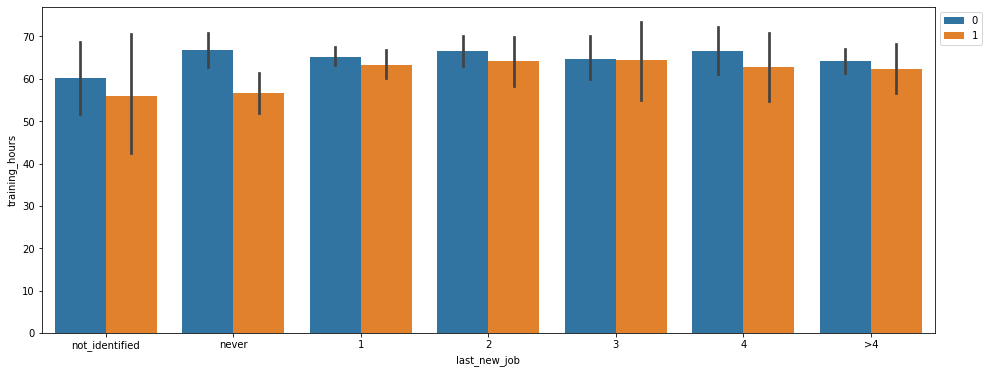

In [31]:
# visualize training hours and last new job with target as hue
plt.figure(figsize=(16, 6))
job_order = ['not_identified', 'never', '1', '2', '3', '4', '>4']
sns.barplot(data=train, x='last_new_job', y='training_hours', hue='target', order=job_order)
plt.legend(bbox_to_anchor=(1, 1), loc=2)

<AxesSubplot:>

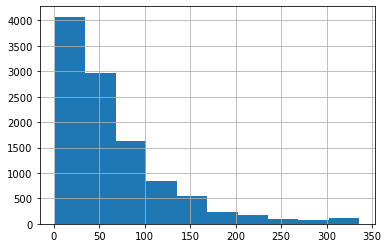

In [32]:
train.training_hours.hist()

**Takeaways**
- convert training_hours and experience to binned/categorical features
- training hours = <25, <50, <90, >90
    - this give most even distribution of groups
- experience = not_identified, <2, <6, <11, <16, more 

In [54]:
train['train_hr_bin'] = pd.cut(train.training_hours, [0, 25, 50, 90, 350], 
                               labels=['<25', '<50', '<90', '>90'])

In [55]:
round(pd.crosstab(train.train_hr_bin, train.target, margins=True, normalize=False), 2)

target,0,1,All
train_hr_bin,,,
<25,2271,780,3051
<50,2027,695,2722
<90,1854,599,2453
>100,1901,601,2502
All,8053,2675,10728


<AxesSubplot:xlabel='target', ylabel='train_hr_bin'>

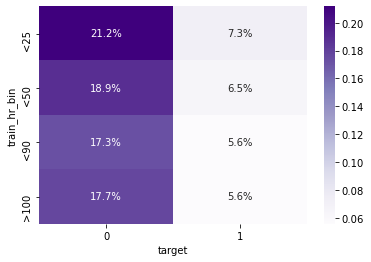

In [61]:
ctab = pd.crosstab(train.train_hr_bin, train.target, margins=False, normalize=True)
sns.heatmap(ctab, cmap='Purples', annot=True, fmt='.1%')

**will need to convert string experience to integer label for binning**     
- if train.experience == '<1' or '1' then 'under 2'
- if train.experience == '2' or '3' or '4' then 'under 5'
- if train.experience == '5' or '6' or '7' or '8' or '9' then 'under 10'
- if train.experience == '10' or '11' or '12' or '13' or '14' then 'under 15'
- if train.experience == '15' or '16' or '17' or '18' or '19' or '20' or '>20' then 'over 15'